Sampling from linear model
=========================

A dataset consisting of three simultaneously obtained data sets (e.g., different photometric bands or RVs determined in individual spectral orders) is constructed and a model is set up with a single slope for all series but individual means. 

In [1]:
import numpy as np
import matplotlib.pylab as plt
from PyAstronomy import funcFit2 as fuf2
import scipy.optimize as sco

In [2]:
# Definition of model 

class LinMod(fuf2.MBOEv):
    """ Linear model """

    def __init__(self, no):
        # no is number of measurement series
        self.no = no
        # 'parnames' specifies parameter names in the model
        parnames = ["mean%d" % (i+1) for i in range(no)]
        parnames.append("slope")
        
        fuf2.MBOEv.__init__(self, pars=parnames, rootName="LinMod")

    def evaluate(self, x, *args, **kwargs):
        """
        Evaluate model at 'x' here and return y = const + x*slope
        """
        r = np.zeros( (len(x), self.no) )
        for i in range(self.no):
            r[::,i] = self["slope"] * x + self["mean%d" % (i+1)]
        
        return r

In [3]:
# Generate mock data
np.random.seed(1718)

# Number of data points and orders
nd = 10
no = 3
# Uncertainty of individual points
s = 0.3

# Mock data and time (x) axis
d = np.zeros((nd,no))
x = np.arange(nd)

for i in range(no):
    offset = np.random.random() * 20
    d[::,i] = 0.6 * x + offset + np.random.normal(0, s, nd)

# Uncertainty
yerr = np.ones_like(d)*s

Optimization terminated successfully.
         Current function value: 32.650283
         Iterations: 272
         Function evaluations: 470
-------------------- Parameter summary ---------------------
    mean1 =      2.35174, free: T, restricted: F, related: F
    mean2 =      3.68232, free: T, restricted: F, related: F
    mean3 =      5.94872, free: T, restricted: F, related: F
    slope =     0.630558, free: T, restricted: F, related: F
------------------------------------------------------------


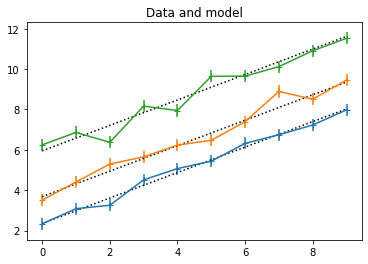

In [4]:
# Get best-fit parameters

# Instantiate model
lm = LinMod(no)
# Guess slope
lm["slope"] = 0.5
# Thaw parameters
lm.thaw(["mean%d" % (i+1) for i in range(no)])
lm.thaw(["slope"])

# Because ln inherited from MBOEv, it has a default chi-square objective function
# Find best-fit parameters
fr = sco.fmin(lm.chisqr, x0=lm.freeParamVals(), args=(x,d,yerr))
# Set model parameters to best-fit values and display
lm.setFreeParamVals(fr)
lm.parameterSummary()

# Plot best-fit model
plt.title("Data and model")
model = lm.evaluate(x)
for i in range(no):
    plt.errorbar(x, d[::,i], yerr=s, fmt='+-')
    plt.plot(x, model[::,i], 'k:')
plt.show()

Parameter mean1, mean =  2.38839, median =  2.39174, std =  0.132071, 95% HPD =  2.12382 -  2.62801
Parameter mean2, mean =  3.77283, median =  3.77296, std =  0.133714, 95% HPD =  3.50435 -  4.02043
Parameter mean3, mean =  5.94215, median =  5.94154, std =  0.128204, 95% HPD =  5.68971 -  6.19776
Parameter slope, mean =  0.624081, median =  0.623544, std =  0.0189487, 95% HPD =  0.588183 -  0.661993


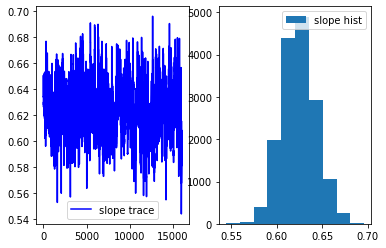

In [5]:
# Sample from the posterior

fuf2.sampleEMCEE2(lm, pargs=(x, d, yerr), dbfile="chain1.emcee", sampleArgs={"burn":300, "iters":1000})


ta = fuf2.TraceAnalysis2("chain1.emcee")

# Calculate mean, median, standard deviation, and
# credibility interval for the available parameters
for p in ta.availableParameters():
  hpd = ta.hpd(p, cred=0.95)
  print("Parameter %5s, mean = % g, median = % g, std = % g, 95%% HPD = % g - % g" \
        % (p, ta.mean(p), ta.median(p), ta.std(p), hpd[0], hpd[1]))

ta.plotTraceHist("slope")
ta.show()